In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import DOP853
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
import numpy as np
from epimodels.discrete.models import SEQIAHR
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import datetime
import lmfit
%matplotlib inline

## Load data

In [53]:
cases = pd.read_csv('covid19_18_06.csv')
# Pegando os casos do Brasil.io
# cases = pd.read_csv('https://brasil.io/dataset/covid19/caso_full/?format=csv')
cases.date = pd.to_datetime(cases.date)

In [54]:
df_states = cases[cases.place_type!='state'].groupby(['date','state']).sum()
df_states.reset_index(inplace=True)
df_states.set_index('date', inplace=True)

In [ ]:
# df_states.set_index('date', inplace=True)
fig,ax = plt.subplots(1,1,figsize=(15,8))

for uf in ['SP','RJ','MG','CE','RS', 'PE', 'AM', 'BA']:
    df_states[df_states.state==uf].last_available_confirmed.plot(ax=ax,style='-o', label=uf, grid=True)

ax.legend()
#plt.savefig('Casos_confirmados_estados.png',dpi=200)

In [ ]:
data = df_states[df_states['state'] == 'SP']['last_available_confirmed']

---

#### Plotar Simulações

In [93]:

def seqihr(y,t,*params):
    S,E,Q,I,H,R = y
    chi,phi,beta(t),rho,delta,alpha = params
    return[
        -beta(t)*S*(I+(1-rho)*H), #dS/dt
        beta(t)*S*(I+(1-rho)*H) - (chi+alpha)*E,#dE/dt
        chi*E -alpha*Q,#dQ/dt
        alpha*E - (phi+delta)*I,#dI/dt
        alpha*Q + phi*I -delta*H,#dH/dt
        delta*I + delta*H,#dR/dt
    ]

chi=.05  # Taxa de quarentenação
phi=.01 # Taxa de Hospitalização
beta=.2 #taxa de Transmissão
rho=.6 # Atenuação da transmissão quando hospitalizado
delta=1/10 # Taxa de recuperação hospitalar
alpha=1/3 # Taxa de incubaçao

inits = [0.9,.1,0,0,0,0]
trange = np.arange(0,100,.1)
res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))


@interact(chi=(0,.1, 0.01),phi=(0,.1,.005),beta=(0,.5,.05),rho=(0,1,.1),delta=(0,1,.05),alpha=(0,1,0.01))
def plota_simulação(chi=0.05,phi=.01,beta=.2,rho=.6,delta=.1,alpha=.33):
    res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.plot(trange,res[:,1:-1])
    ax.set_ylabel('Fração da População')
    ax.set_xlabel('Tempo (dias)')
    ax.grid()
    ax.legend(['Exposto','Quar','Inf','Hosp','Rec']);

SyntaxError: can't assign to function call (<ipython-input-93-fc9f0e6d6f88>, line 4)

In [39]:
odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))[:,1:-1]

array([[1.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.62683766e-02, 4.82448153e-04, 3.25253813e-03, 9.74527802e-06],
       [9.27332592e-02, 9.31219401e-04, 6.34908065e-03, 3.79876249e-05],
       ...,
       [1.16912968e-03, 2.09111528e-04, 6.78546789e-03, 2.75569440e-03],
       [1.16285705e-03, 2.07989805e-04, 6.74988988e-03, 2.74192569e-03],
       [1.15661807e-03, 2.06874092e-04, 6.71449370e-03, 2.72822157e-03]])

### Fit model

In [102]:
chi=.05  # Taxa de quarentenação
phi=.01 # Taxa de Hospitalização
#beta=.2 #taxa de Transmissão
rho=.6 # Atenuação da transmissão quando hospitalizado
delta=1/10 # Taxa de recuperação hospitalar
alpha=1/3 # Taxa de incubaçao

def seqihr(y,t,chi,phi,beta,rho,delta,alpha):
    S,E,Q,I,H,R = y
    #chi,phi,beta(t),rho,delta,alpha = params
    return[
        -beta(t)*S*(I+(1-rho)*H), #dS/dt
        beta(t)*S*(I+(1-rho)*H) - (chi+alpha)*E,#dE/dt
        chi*E -alpha*Q,#dQ/dt
        alpha*E - (phi+delta)*I,#dI/dt
        alpha*Q + phi*I -delta*H,#dH/dt
        delta*I + delta*H,#dR/dt
    ]
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, R_0_start, k, x0, R_0_end):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) 

    
    ret = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))
    S,E,Q,I,H,R  = ret.T
    
    
    return S,E,Q,I,H,R



outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                    }  # form: {parameter: (initial guess, minimum value, max value)}

days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x,R_0_start, k, x0, R_0_end):
    ret = Model(days, R_0_start, k, x0, R_0_end)
    return ret[3][x]

In [75]:
outbreak_shift = 30
'''params_init_min_max = {"chi": (0.5, 0.01, 1), "phi": (.01, 0.01, 1), "beta": (0.2, 0.01, 1), "rho": (0.6, 0, 1),
                       "delta": (0.1, 0, 1), "alpha": (0.33, 0.0, 10)
        }  # form: {parameter: (initial guess, minimum value, max value)}'''

params_init_min_max = {"beta": (0.2, 0.01, 1)}


days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [64]:
def fitter(x,chi,phi,beta,rho,delta,alpha):
    ret = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))
    ret = ret.T
    return ret[5][x]

In [114]:
mod = lmfit.Model(model([1000, 1, 0], [0, 50], 1001, {'beta': 0.2, 'gamma': .1}))

In [104]:
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [115]:
result = mod.fit(y_data, params,method="least_squares", x=x_data)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\lmfit\model.py:960: UserWarning: The keyword argument x does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)


TypeError: 'NoneType' object is not callable

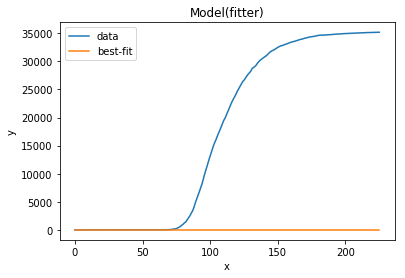

In [106]:
result.plot_fit(datafmt="-");

In [107]:
params

name,value,initial value,min,max,vary
R_0_start,3.00000000,None,2.00000000,5.00000000,True
k,2.50000000,None,0.01000000,5.00000000,True
x0,90.0000000,None,0.00000000,120.000000,True
R_0_end,0.90000000,None,0.30000000,3.50000000,True


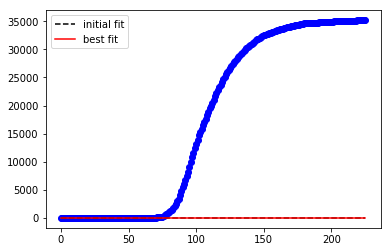

In [28]:
plt.plot(x_data, y_data, 'bo')
plt.plot(x_data, result.init_fit, 'k--', label='initial fit')
plt.plot(x_data, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [30]:
result.best_fit

array([0.00000000e+00, 5.38944094e-04, 1.88463677e-03, 3.76093107e-03,
       6.00742970e-03, 8.53187816e-03, 1.12821518e-02, 1.42297642e-02,
       1.73601517e-02, 2.06669414e-02, 2.41485605e-02, 2.78062234e-02,
       3.16427284e-02, 3.56617320e-02, 3.98673036e-02, 4.42636445e-02,
       4.88549059e-02, 5.36450627e-02, 5.86378218e-02, 6.38365509e-02,
       6.92442194e-02, 7.48633477e-02, 8.06959630e-02, 8.67435575e-02,
       9.30070526e-02, 9.94867671e-02, 1.06182388e-01, 1.13092950e-01,
       1.20216811e-01, 1.27551649e-01, 1.35094446e-01, 1.42841488e-01,
       1.50788374e-01, 1.58930025e-01, 1.67260699e-01, 1.75774017e-01,
       1.84462989e-01, 1.93320052e-01, 2.02337105e-01, 2.11505557e-01,
       2.20816371e-01, 2.30260116e-01, 2.39827019e-01, 2.49507025e-01,
       2.59289845e-01, 2.69165022e-01, 2.79121977e-01, 2.89150072e-01,
       2.99238660e-01, 3.09377137e-01, 3.19554992e-01, 3.29761851e-01,
       3.39987518e-01, 3.50222020e-01, 3.60455635e-01, 3.70678927e-01,
      

In [27]:
x_data

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [31]:
mod.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
alpha      0.33        0       10     True    
beta        0.2        0        1     True    
chi         0.5        0        1     True    
delta       0.1        0        1     True    
phi        0.01        0        1     True    
rho         0.6        0        1     True    


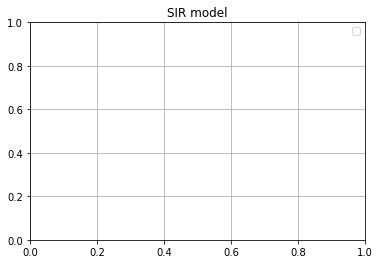

In [109]:
from epimodels.continuous.models import SIR
model = SIR()
model([1000, 1, 0], [0, 50], 1001, {'beta': 0.2, 'gamma': .1})
model.plot_traces()